<h2> 3.4 Computing Similarity matrices </h2>

<h3> 3.4.1 Computing User-User Similarity matrix </h3>

1. Calculating User User Similarity_Matrix is __not very easy__(_unless you have huge Computing Power and lots of time_) because of number of. usersbeing lare.

    * You can try if you want to. Your system could crash or the program stops with **Memory Error**


<h4> 3.4.1.1 Trying with all dimensions (17k dimensions per user) </h4>

In [0]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 20,
                            draw_time_taken=True):
    no_of_users, _ = sparse_matrix.shape
    # get the indices of  non zero rows(users) from our sparse matrix
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) # we don't have to
    time_taken = list() #  time taken for finding similar users for an user..
    
    # we create rows, cols, and data lists.., which can be used to create sparse matrices
    rows, cols, data = list(), list(), list()
    if verbose: print("Computing top",top,"similarities for each user..")
    
    start = datetime.now()
    temp = 0
    
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        
        # get the similarity row for this user with all other users
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        # We will get only the top ''top'' most similar users and ignore rest of them..
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        
        # add them to our rows, cols and data
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
            
        
    # lets create sparse matrix out of these and return it
    if verbose: print('Creating Sparse matrix from the computed similarities')
    #return rows, cols, data
    
    if draw_time_taken:
        plt.plot(time_taken, label = 'time taken for each user')
        plt.plot(np.cumsum(time_taken), label='Total time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken      

Computing top 100 similarities for each user..
computing done for 20 users [  time elapsed : 0:03:20.300488  ]
computing done for 40 users [  time elapsed : 0:06:38.518391  ]
computing done for 60 users [  time elapsed : 0:09:53.143126  ]
computing done for 80 users [  time elapsed : 0:13:10.080447  ]
computing done for 100 users [  time elapsed : 0:16:24.711032  ]
Creating Sparse matrix from the computed similarities


<IPython.core.display.Javascript object>


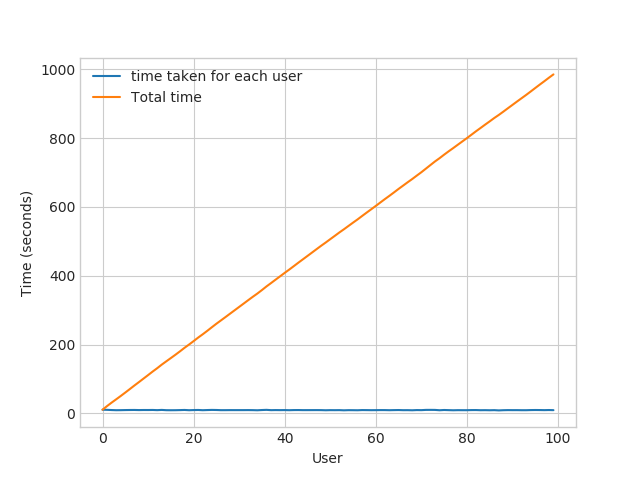

----------------------------------------------------------------------------------------------------
Time taken : 0:16:33.618931


In [0]:
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 100,
                                                     verbose=True)
print("-"*100)
print("Time taken :",datetime.now()-start)

<h4> 3.4.1.2 Trying with reduced dimensions (Using TruncatedSVD for dimensionality reduction of user vector)</h4>

* We have  **405,041 users** in out training set and computing similarities between them..( **17K dimensional vector..**) is time consuming..


- From above plot, It took roughly __8.88 sec__ for computing simlilar users for __one user__
    
    
- We have __405,041 users__ with us in training set.


- ${ 405041 \times 8.88 = 3596764.08  \sec } =  59946.068 \min = 999.101133333 \text{ hours}
= 41.629213889 \text{ days}...$

    - Even if we run on 4 cores parallelly (a typical system now a days), It will still take almost __10 and 1/2__ days.
    
 IDEA:  Instead, we will try to reduce the dimentsions using SVD, so that __it might__ speed up the process...

In [0]:
from datetime import datetime
from sklearn.decomposition import TruncatedSVD

start = datetime.now()

# initilaize the algorithm with some parameters..
# All of them are default except n_components. n_itr is for Randomized SVD solver.
netflix_svd = TruncatedSVD(n_components=500, algorithm='randomized', random_state=15)
trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)

print(datetime.now()-start)

0:29:07.069783


Here,


- $\sum \longleftarrow$ (netflix\_svd.**singular\_values\_** )


- $\bigvee^T \longleftarrow$ (netflix\_svd.**components_**)


- $\bigcup$ is not returned. instead **Projection_of_X** onto the new vectorspace is returned. 


- It uses **randomized svd** internally, which returns **All 3 of them saperately**. Use that instead.. 

In [0]:
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)

<IPython.core.display.Javascript object>


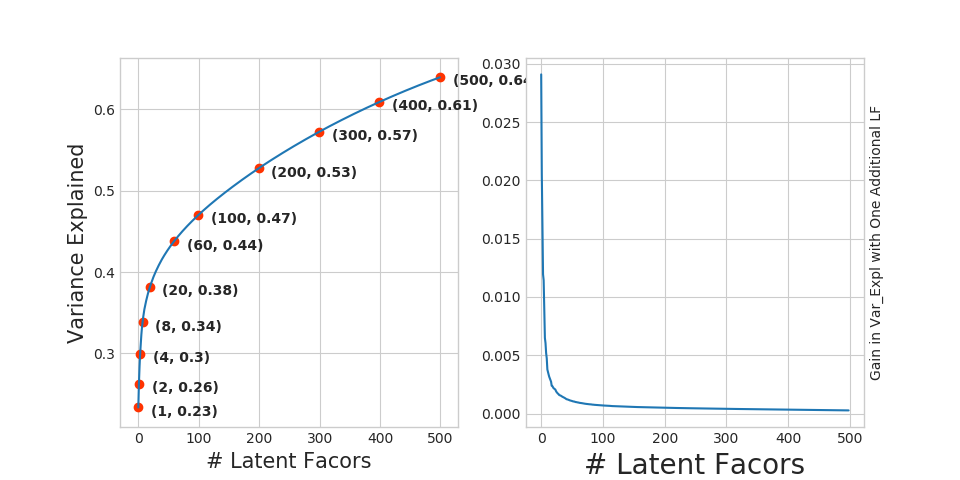

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))

ax1.set_ylabel("Variance Explained", fontsize=15)
ax1.set_xlabel("# Latent Facors", fontsize=15)
ax1.plot(expl_var)
# annote some (latentfactors, expl_var) to make it clear
ind = [1, 2,4,8,20, 60, 100, 200, 300, 400, 500]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c='#ff3300')
for i in ind:
    ax1.annotate(s ="({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01), fontweight='bold')

change_in_expl_var = [expl_var[i+1] - expl_var[i] for i in range(len(expl_var)-1)]
ax2.plot(change_in_expl_var)



ax2.set_ylabel("Gain in Var_Expl with One Additional LF", fontsize=10)
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("# Latent Facors", fontsize=20)

plt.show()

In [0]:
for i in ind:
    print("({}, {})".format(i, np.round(expl_var[i-1], 2)))

(1, 0.23)
(2, 0.26)
(4, 0.3)
(8, 0.34)
(20, 0.38)
(60, 0.44)
(100, 0.47)
(200, 0.53)
(300, 0.57)
(400, 0.61)
(500, 0.64)


 
> I think 500 dimensions is good enough 

---------

-  By just taking __(20 to 30)__ latent factors, explained variance that we could get is __20 %__. 

- To take it to __60%__, we have to take  __almost 400 latent factors__. It is not fare.



- It basically is the __gain of variance explained__, if we ___add one additional latent factor to it.___


- By adding one by one latent factore too it, the ___gain in expained variance__ with that addition is decreasing. (Obviously, because they are sorted that way).
- ___LHS Graph___:
    - __x__ --- ( No of latent factos ),
    - __y__ --- ( The variance explained by taking x latent factors)



- __More decrease in the line (RHS graph) __:
    - We  are getting more expained variance than before.
- __Less decrease in that line (RHS graph)__  :
    - We are not getting benifitted from adding latent factor furthur. This is what is shown in the plots.


- ___RHS Graph___:
    - __x__ --- ( No of latent factors ),
    - __y__ --- ( Gain n Expl_Var by taking one additional latent factor) 

In [0]:
# Let's project our Original U_M matrix into into 500 Dimensional space...
start = datetime.now()
trunc_matrix = train_sparse_matrix.dot(netflix_svd.components_.T)
print(datetime.now()- start)

0:00:45.670265


In [0]:
type(trunc_matrix), trunc_matrix.shape

(numpy.ndarray, (2649430, 500))

* Let's convert this to actual sparse matrix and store it for future purposes

In [0]:
if not os.path.isfile('trunc_sparse_matrix.npz'):
    # create that sparse sparse matrix
    trunc_sparse_matrix = sparse.csr_matrix(trunc_matrix)
    # Save this truncated sparse matrix for later usage..
    sparse.save_npz('trunc_sparse_matrix', trunc_sparse_matrix)
else:
    trunc_sparse_matrix = sparse.load_npz('trunc_sparse_matrix.npz')

In [0]:
trunc_sparse_matrix.shape

(2649430, 500)

Computing top 50 similarities for each user..
computing done for 10 users [  time elapsed : 0:02:09.746324  ]
computing done for 20 users [  time elapsed : 0:04:16.017768  ]
computing done for 30 users [  time elapsed : 0:06:20.861163  ]
computing done for 40 users [  time elapsed : 0:08:24.933316  ]
computing done for 50 users [  time elapsed : 0:10:28.861485  ]
Creating Sparse matrix from the computed similarities


<IPython.core.display.Javascript object>


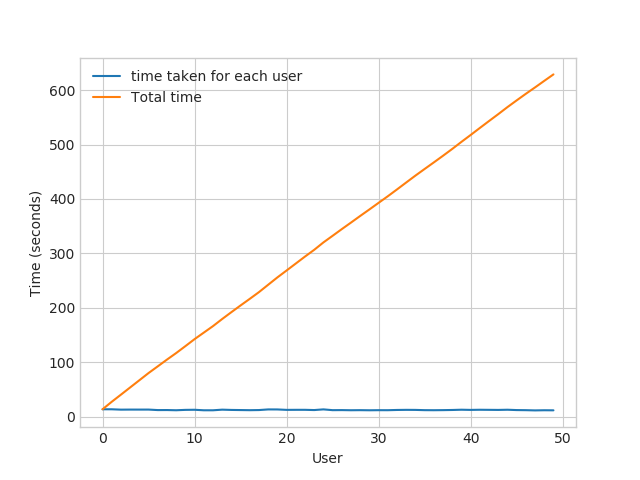

--------------------------------------------------
time: 0:10:52.658092


In [0]:
start = datetime.now()
trunc_u_u_sim_matrix, _ = compute_user_similarity(trunc_sparse_matrix, compute_for_few=True, top=50, verbose=True, 
                                                 verb_for_n_rows=10)
print("-"*50)
print("time:",datetime.now()-start)

**: This is taking more time for each user than Original one.**

- from above plot, It took almost __12.18__ for computing simlilar users for __one user__
    
    
- We have __405041 users__ with us in training set.


- ${ 405041 \times 12.18 ==== 4933399.38 \sec } ====  82223.323 \min ==== 1370.388716667 \text{ hours}
==== 57.099529861 \text{ days}...$

    - Even we run on 4 cores parallelly (a typical system now a days), It will still take almost __(14 - 15) __ days.


- __Why did this happen...??__


    - Just think about it. It's not that difficult.

---------------------------------_( sparse & dense..................get it ?? )_-----------------------------------

__Is there any other way to compute user user similarity..??__

-An alternative is to compute similar users for a particular user,  whenenver required (**ie., Run time**)
    - We maintain a binary Vector for users, which tells us whether we already computed or not..
    - ***If not*** : 
        - Compute top (let's just say, 1000) most similar users for this given user, and add this to our datastructure, so that we can just access it(similar users) without recomputing it again.
        - 
    - ***If It is already Computed***:
        - Just get it directly from our datastructure, which has that information.
        - In production time, We might have to recompute similarities, if it is computed a long time ago. Because user preferences changes over time. If we could maintain some kind of Timer, which when expires, we have to update it ( recompute it ). 
        - 
    - ***Which datastructure to use:***
        - It is purely implementation dependant. 
        - One simple method is to maintain a **Dictionary Of Dictionaries**.
            - 
            - **key    :** _userid_ 
            - __value__: _Again a dictionary_
                - __key__  : _Similar User_
                - __value__: _Similarity Value_

<h3> 3.4.2 Computing Movie-Movie Similarity matrix </h3>

In [0]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)

It seems you don't have that file. Computing movie_movie similarity...
Done..
Saving it to disk without the need of re-computing it again.. 
Done..
It's a  (17771, 17771)  dimensional matrix
0:10:02.736054


In [0]:
m_m_sim_sparse.shape

(17771, 17771)

- Even though we have similarity measure of each movie, with all other movies, We generally don't care much about least similar movies.


- Most of the times, only top_xxx similar items matters. It may be 10 or 100.


- We take only those top similar movie ratings and store them  in a saperate dictionary.

In [0]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [0]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

# just testing similar movies for movie_15
similar_movies[15]

0:00:33.411700


array([ 8279,  8013, 16528,  5927, 13105, 12049,  4424, 10193, 17590,
        4549,  3755,   590, 14059, 15144, 15054,  9584,  9071,  6349,
       16402,  3973,  1720,  5370, 16309,  9376,  6116,  4706,  2818,
         778, 15331,  1416, 12979, 17139, 17710,  5452,  2534,   164,
       15188,  8323,  2450, 16331,  9566, 15301, 13213, 14308, 15984,
       10597,  6426,  5500,  7068,  7328,  5720,  9802,   376, 13013,
        8003, 10199,  3338, 15390,  9688, 16455, 11730,  4513,   598,
       12762,  2187,   509,  5865,  9166, 17115, 16334,  1942,  7282,
       17584,  4376,  8988,  8873,  5921,  2716, 14679, 11947, 11981,
        4649,   565, 12954, 10788, 10220, 10963,  9427,  1690,  5107,
        7859,  5969,  1510,  2429,   847,  7845,  6410, 13931,  9840,
        3706])

<h3> 3.4.3 Finding most similar movies using similarity matrix </h3>

__ Does Similarity really works as the way we expected...? __ <br>
_Let's pick some random movie and check for its similar movies...._

In [0]:
# First Let's load the movie details into soe dataframe..
# movie details are in 'netflix/movie_titles.csv'

movie_titles = pd.read_csv("data_folder/movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")

movie_titles.head()

Tokenization took: 4.50 ms
Type conversion took: 165.72 ms
Parser memory cleanup took: 0.01 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


<p style='font-size:15px'><b>Similar Movies for 'Vampire Journals'</b></p>

In [0]:
mv_id = 67

print("\nMovie ----->",movie_titles.loc[mv_id].values[1])

print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))

print("\nWe have {} movies which are similarto this  and we will get only top most..".format(m_m_sim_sparse[:,mv_id].getnnz()))


Movie -----> Vampire Journals

It has 270 Ratings from users.

We have 17284 movies which are similarto this  and we will get only top most..


In [0]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()

similar_indices = similarities.argsort()[::-1][1:]

similarities[similar_indices]

sim_indices = similarities.argsort()[::-1][1:] # It will sort and reverse the array and ignore its similarity (ie.,1)
                                               # and return its indices(movie_ids)

<IPython.core.display.Javascript object>


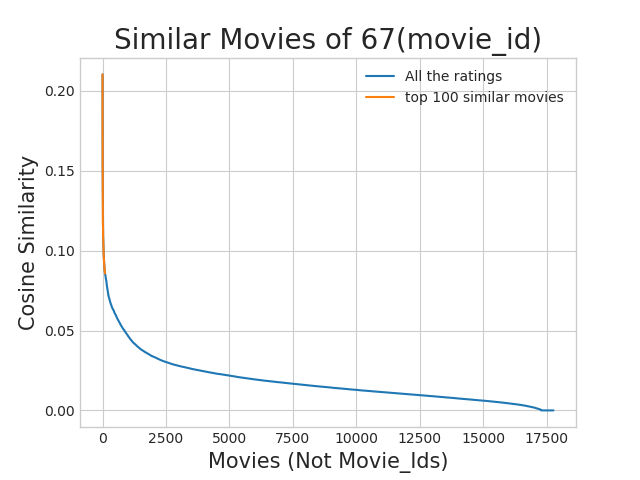

In [0]:
plt.plot(similarities[sim_indices], label='All the ratings')
plt.plot(similarities[sim_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize=20)
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

__Top 10 similar movies__

In [0]:
movie_titles.loc[sim_indices[:10]]

,year_of_release,title
movie_id,,
323,1999.0,Modern Vampires
4044,1998.0,Subspecies 4: Bloodstorm
1688,1993.0,To Sleep With a Vampire
13962,2001.0,Dracula: The Dark Prince
12053,1993.0,Dracula Rising
16279,2002.0,Vampires: Los Muertos
4667,1996.0,Vampirella
1900,1997.0,Club Vampire
13873,2001.0,The Breed


 > Similarly, we can ___find similar users___ and compare how similar they are. 